In [1]:
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0" #model will be trained on GPU 0

In [2]:
import keras

Using TensorFlow backend.


In [3]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model

In [4]:
#################
# Encoder part: # (WITH MUCHAS THANKS TO https://stackoverflow.com/questions/48603328/how-do-i-split-an-convolutional-autoencoder)
#################
def encoder():
    # This function returns a model object of the encoder
    input_img = Input(shape=(28, 28, 1))                               # create an input layer for a 28x28 grayscale image
    e1 = Conv2D(16,(3,3),activation='relu', padding='same')(input_img) # create 16 3x3-filters with ReLU and 'same'-padding
    e2 = MaxPooling2D((2,2),padding='same')(e1)                        # apply downsampling (max) with 2x2 kernel and 'same'-padding
    e3 = Conv2D(8,(3,3),activation='relu', padding ='same')(e2)        # create 8  3x3-filters with ReLU and 'same'-padding
    e4 = MaxPooling2D((2,2),padding='same')(e3)                        # apply downampling (max) with 2x2 kernel and 'same'-padding
    e5 = Conv2D(8,(3,3),activation='relu', padding='same')(e4)         # create 8  3x3-filters 2with ReLU and 'same'-padding
    e6 = MaxPooling2D((2,2),padding='same')(e5)                        # apply downsampling (max) with 2x2 kernel and 'same'-padding
    return Model(input_img, e6)
#################
# Decoder part: # (we apply the same layers but in inverse order (and replace downsampling with upsampling))
#################
def decoder():
    input_img = Input(shape=(4, 4, 8))  # adapt this if using `channels_first` image data format   
    d1 = Conv2D(8, (3, 3), activation='relu', padding='same')(input_img)
    d2 = UpSampling2D((2, 2))(d1)
    d3 = Conv2D(8, (3, 3), activation='relu', padding='same')(d2)
    d4 = UpSampling2D((2, 2))(d3)
    d5 = Conv2D(16, (3, 3), activation='relu')(d4)
    d6 = UpSampling2D((2, 2))(d5)
    d7 = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(d6)
    return Model(input_img, d7)


# define input to the model:
x = Input(shape=(28, 28, 1))
# make the model:
autoencoder = Model(x, decoder()(encoder()(x)))
# compile the model:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [5]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

11493376/11490434 [==============================] - 7s 1us/step


In [6]:
import datetime
begin = datetime.datetime.now()

history = autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

passed = datetime.datetime.now() - begin
print("Training time = %s" % (passed))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 8s 128us/step - loss: 0.2258 - val_loss: 0.1738
Epoch 2/50
60000/60000 [==============================] - 4s 71us/step - loss: 0.1641 - val_loss: 0.1532
Epoch 3/50
60000/60000 [==============================] - 4s 72us/step - loss: 0.1489 - val_loss: 0.1436
Epoch 4/50
60000/60000 [==============================] - 4s 72us/step - loss: 0.1393 - val_loss: 0.1355
Epoch 5/50
60000/60000 [==============================] - 4s 72us/step - loss: 0.1331 - val_loss: 0.1283
Epoch 6/50
60000/60000 [==============================] - 4s 72us/step - loss: 0.1290 - val_loss: 0.1251
Epoch 7/50
60000/60000 [==============================] - 4s 71us/step - loss: 0.1257 - val_loss: 0.1250
Epoch 8/50
60000/60000 [==============================] - 4s 72us/step - loss: 0.1235 - val_loss: 0.1207
Epoch 9/50
60000/60000 [==============================] - 4s 72us/step - loss: 0.1218 - val_loss: 0.1230
Epoc

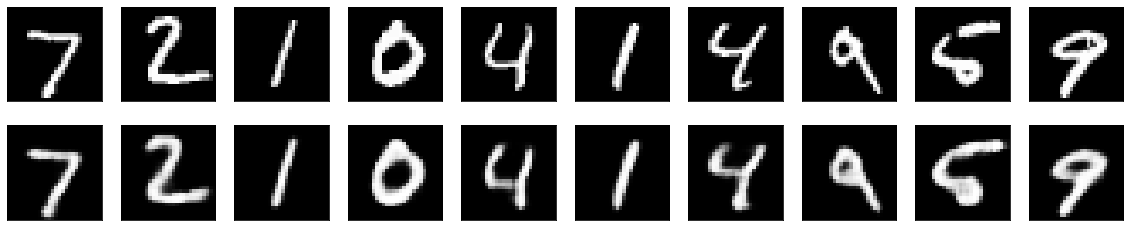

In [7]:
import matplotlib.pyplot as plt

decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n+1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

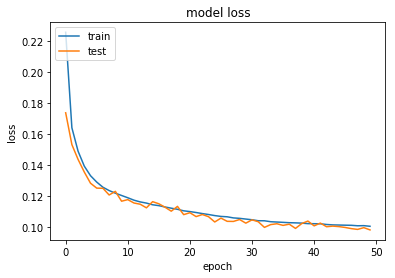

In [8]:
# Plot training and validation loss
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [9]:
# Export models for the encoder and decoder
decoder().save('decoder.h5')
encoder().save('encoder.h5')